# Classifying Knee Images - Simplified Classes

We originally started off with a dataset containing knee X-ray images grading knee osteoarthritis as follows:

  * Grade __0__: Healthy knee image.
  * Grade __1__ (Doubtful): Doubtful joint narrowing with possible osteophytic lipping
  * Grade __2__ (Minimal): Definite presence of osteophytes and possible joint space narrowing
  * Grade __3__ (Moderate): Multiple osteophytes, definite joint space narrowing, with mild sclerosis.
  * Grade __4__ (Severe): Large osteophytes, significant joint narrowing, and severe sclerosis.

However, the model was unable to classify the images with much accuracy (accuracy maxed out in the 50% range).

Thus, in order to improve our model detection, we will simplify the classes as follows:

  * __A__ : contains Grades __0__ and __1__ : indicates a reasonably healthy knee, wherein a patient with knee pain may wish to explore other causes
  * __B__ : contains Grade __2__ : indicates that patient with knee pain stemming from OA should consider lifestyle changes, and possibly medication
  * __C__ : contains Grades __3__ and __4__ : indicates to patient that knee replacement and other procedures and/or surgeries may be an option

## 1 Setup

### 1.1 Imports

In [1]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import os
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.applications import DenseNet201

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

TensorFlow version:  2.5.0


### 1.2 Constants

In [2]:
BATCH_SIZE = 32
TARGET_IMG_HEIGHT = 224 # keeping the original resolution
TARGET_IMG_WIDTH = 224
CLASS_MODE_CATEGORICAL = 'categorical'
INTERPOLATION_BILINEAR = 'bilinear'

## 2 Load the data

### 2.1 Different loading criteria
Code will differ based on whether we are running on Google Colab or on a local machine

#### 2.1.1 On local machine

In [3]:
# directory = "../data/"

#### 2.1.2 On Google Colab

In [4]:
!wget --no-check-certificate \
    "https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip" \
    -O "/tmp/knee-data.zip"

zip_ref = zipfile.ZipFile('/tmp/knee-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-07-05 04:17:53--  https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main [following]
--2021-07-05 04:17:53--  https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/knee-data.zip’

/tmp/knee-data.zip      [               <=>  ] 173.90M  47.3MB/s    in 3.7s    

2021-07-05 04:17:57 (46.6 MB/s) - ‘/tmp/knee-data.zip’ saved [182351735]



In [5]:
!ls /tmp/KneeOsteoarthritis-main/data/

test  train  val


In [6]:
os.listdir("/tmp/KneeOsteoarthritis-main/data/")

['val', 'test', 'train']

In [7]:
directory = "/tmp/KneeOsteoarthritis-main/data/"

In [8]:
[x[0] for x in os.walk(directory)]

['/tmp/KneeOsteoarthritis-main/data/',
 '/tmp/KneeOsteoarthritis-main/data/val',
 '/tmp/KneeOsteoarthritis-main/data/val/2',
 '/tmp/KneeOsteoarthritis-main/data/val/3',
 '/tmp/KneeOsteoarthritis-main/data/val/0',
 '/tmp/KneeOsteoarthritis-main/data/val/1',
 '/tmp/KneeOsteoarthritis-main/data/val/4',
 '/tmp/KneeOsteoarthritis-main/data/test',
 '/tmp/KneeOsteoarthritis-main/data/test/2',
 '/tmp/KneeOsteoarthritis-main/data/test/3',
 '/tmp/KneeOsteoarthritis-main/data/test/0',
 '/tmp/KneeOsteoarthritis-main/data/test/1',
 '/tmp/KneeOsteoarthritis-main/data/test/4',
 '/tmp/KneeOsteoarthritis-main/data/train',
 '/tmp/KneeOsteoarthritis-main/data/train/2',
 '/tmp/KneeOsteoarthritis-main/data/train/3',
 '/tmp/KneeOsteoarthritis-main/data/train/0',
 '/tmp/KneeOsteoarthritis-main/data/train/1',
 '/tmp/KneeOsteoarthritis-main/data/train/4']

##### 2.1.2.1 Simplifying the classes

We will now simplify the classes of the knee grades as follows:
  * Grades 0 and 1 become Class A
  * Grade 2 becomes Class B
  * Grades 3 and 4 become Class C

In [9]:
simplifying_dict = {'A':[0, 1], 'B':[2], 'C':[3, 4]}

In [10]:
for sub_dir in os.listdir(directory):
  sub_dir_path = directory + sub_dir + '/'
  for k,v in simplifying_dict.items():
    dest = sub_dir_path + k
    print('moving to ', dest)
    os.mkdir(dest)
    for grade in v:
      src = sub_dir_path + str(grade)
      print('... from ', src)
      files = os.listdir(src)
      for file in files:
        shutil.move(src + '/' + file, dest)
      os.rmdir(src)

moving to  /tmp/KneeOsteoarthritis-main/data/val/A
... from  /tmp/KneeOsteoarthritis-main/data/val/0
... from  /tmp/KneeOsteoarthritis-main/data/val/1
moving to  /tmp/KneeOsteoarthritis-main/data/val/B
... from  /tmp/KneeOsteoarthritis-main/data/val/2
moving to  /tmp/KneeOsteoarthritis-main/data/val/C
... from  /tmp/KneeOsteoarthritis-main/data/val/3
... from  /tmp/KneeOsteoarthritis-main/data/val/4
moving to  /tmp/KneeOsteoarthritis-main/data/test/A
... from  /tmp/KneeOsteoarthritis-main/data/test/0
... from  /tmp/KneeOsteoarthritis-main/data/test/1
moving to  /tmp/KneeOsteoarthritis-main/data/test/B
... from  /tmp/KneeOsteoarthritis-main/data/test/2
moving to  /tmp/KneeOsteoarthritis-main/data/test/C
... from  /tmp/KneeOsteoarthritis-main/data/test/3
... from  /tmp/KneeOsteoarthritis-main/data/test/4
moving to  /tmp/KneeOsteoarthritis-main/data/train/A
... from  /tmp/KneeOsteoarthritis-main/data/train/0
... from  /tmp/KneeOsteoarthritis-main/data/train/1
moving to  /tmp/KneeOsteoarth

In [11]:
[x[0] for x in os.walk(directory)]

['/tmp/KneeOsteoarthritis-main/data/',
 '/tmp/KneeOsteoarthritis-main/data/val',
 '/tmp/KneeOsteoarthritis-main/data/val/C',
 '/tmp/KneeOsteoarthritis-main/data/val/A',
 '/tmp/KneeOsteoarthritis-main/data/val/B',
 '/tmp/KneeOsteoarthritis-main/data/test',
 '/tmp/KneeOsteoarthritis-main/data/test/C',
 '/tmp/KneeOsteoarthritis-main/data/test/A',
 '/tmp/KneeOsteoarthritis-main/data/test/B',
 '/tmp/KneeOsteoarthritis-main/data/train',
 '/tmp/KneeOsteoarthritis-main/data/train/C',
 '/tmp/KneeOsteoarthritis-main/data/train/A',
 '/tmp/KneeOsteoarthritis-main/data/train/B']

### 2.2 Load files

In [12]:
train_directory = directory + "train"
val_directory = directory + "val"
test_directory = directory + "test"

In [13]:
# create a normal, non-augmented data generator
datagen_normal = ImageDataGenerator()

# create an augmented data generator
# since we will be processing Knee X-rays, we will allow the following augmentations:
# vertical flipping, zooming, rotating, shearing, brightness
datagen_augment = ImageDataGenerator(rotation_range=10,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     brightness_range=[0.3,0.9],
                                     shear_range=0.25,
                                     zoom_range=0.1,
                                     channel_shift_range = 20,
                                     horizontal_flip = True,
                                     fill_mode='constant')

In [14]:
def get_image_data_from_directory( dir_path, augment_data_param = False, shuffle_param = False):
    datagen = datagen_augment if augment_data_param == True else datagen_normal
    return datagen.flow_from_directory(
        dir_path,
        target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=shuffle_param,
        class_mode=CLASS_MODE_CATEGORICAL,
        interpolation=INTERPOLATION_BILINEAR)

#### 2.2.1 Load training set

In [15]:
# augment data and shuffle the training dataset
train_generator = get_image_data_from_directory(train_directory, True, True) 

Found 5778 images belonging to 3 classes.


#### 2.2.2 Load validation set

In [16]:
val_generator = get_image_data_from_directory(val_directory)

Found 826 images belonging to 3 classes.


#### 2.2.3 Load test set

In [17]:
test_generator = get_image_data_from_directory(test_directory) 

Found 1656 images belonging to 3 classes.


### 2.3 Get files for use with distribution plots and samples

In [18]:
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [19]:
train_files = fetch_files_from_directory(train_directory)
val_files = fetch_files_from_directory(val_directory)
test_files = fetch_files_from_directory(test_directory)

#### 2.3.1 Verifying uniqueness of each image file

In [20]:
def create_image_list( files_dict ):
    image_list = []
    for files in files_dict.values():
        image_list.extend(files)
    return image_list

In [21]:
image_list_train = create_image_list(train_files)
image_list_val = create_image_list(val_files)
image_list_test = create_image_list(test_files)

all_image_list = []
all_image_list.extend(image_list_train)
all_image_list.extend(image_list_val)
all_image_list.extend(image_list_test)

In [22]:
print('# of files in train_dir: ', len(image_list_train))
print('# of files in val_dir: ', len(image_list_val))
print('# of files in test_dir: ', len(image_list_test))
print('total # of files: ', len(all_image_list))

# of files in train_dir:  5778
# of files in val_dir:  826
# of files in test_dir:  1656
total # of files:  8260


In [23]:
print(5778 + 826 + 1656)

8260


In [24]:
all_image_set = set(all_image_list)
print('total # of unique files: ', len(all_image_set))

total # of unique files:  8260


We have verified that each image file across the train, validation, and test directories is unique (there is no cross-contamination).

## 3 Explore the data

In [25]:
print('Training data: contains {} images, batch size of {}'.format(train_generator.n, train_generator.batch_size))
print('Validation data: contains {} images, batch size of {}'.format(val_generator.n, val_generator.batch_size))
print('Testing data: contains {} images, batch size of {}'.format(test_generator.n, test_generator.batch_size))

Training data: contains 5778 images, batch size of 32
Validation data: contains 826 images, batch size of 32
Testing data: contains 1656 images, batch size of 32


In [26]:
sns.set_style("dark")

In [27]:
class_labels = ['A','B','C']

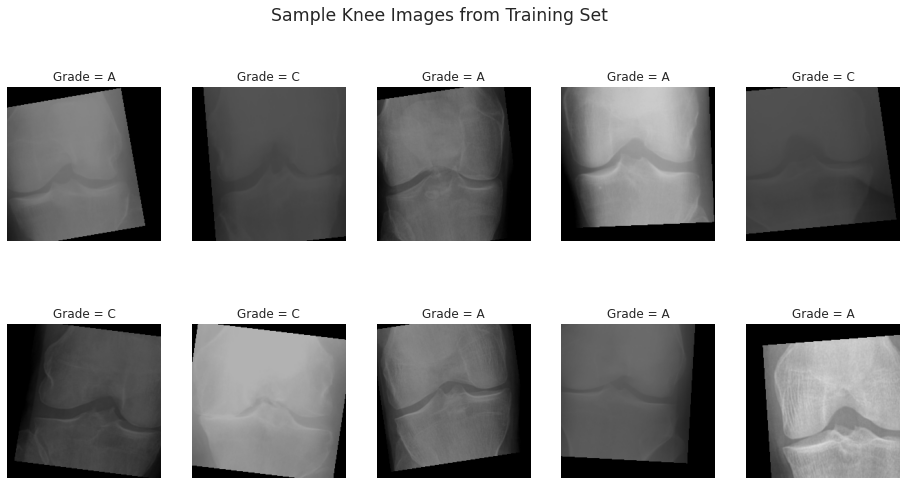

In [28]:
plt.figure(figsize=(16, 8))
for i in range(1):
    images, labels = next(train_generator)
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        ax.axis('off')
        plt.imshow(images[i].squeeze().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + class_labels[np.argmax(labels[i])])
_ = plt.suptitle('Sample Knee Images from Training Set', size='xx-large')

train_generator.reset()

In [29]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(16,6))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    g = sns.barplot(x=keys, y=vals, palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)
    
    # display values atop bars
    for i, p in enumerate(ax.patches):
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height() * 0.015)
        value = '{:.0f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center") 

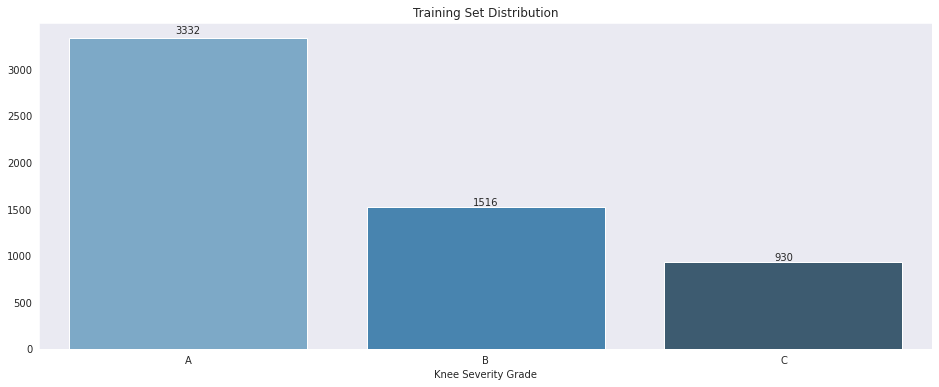

In [30]:
plot_distribution(train_files, 'Training Set Distribution')

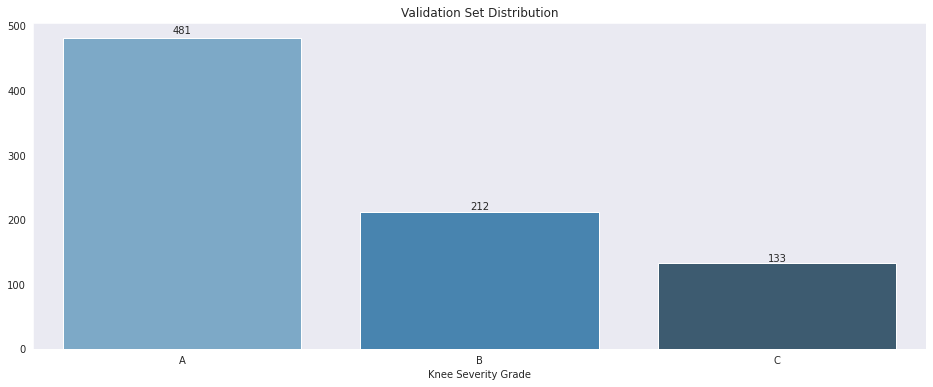

In [31]:
plot_distribution(val_files, 'Validation Set Distribution')

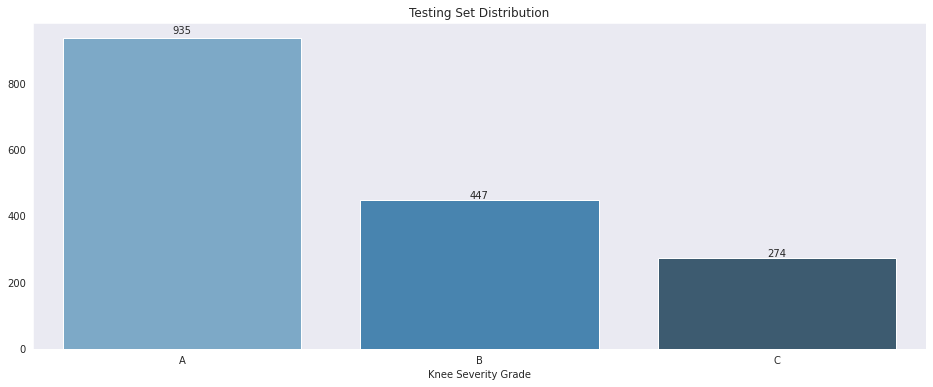

In [32]:
plot_distribution(test_files, 'Testing Set Distribution')

## 4 Model - Transfer Learning - DenseNet201

### 4.1 Building the model

In [59]:
base_model = DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH, 3),
    include_top=False,  # Do not include the ImageNet classifier at the top.
    pooling='max')

In [60]:
base_model.trainable = False

In [61]:
inputs = Input(shape=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH, 3))

## for DenseNet, add a rescaling layer to input
x = Rescaling(1./255)(inputs)

x = base_model(x, training=False)

x = BatchNormalization(axis=-1, momentum=0.75, epsilon=0.001)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

num_classes = len(class_labels)

outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [62]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [63]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075

Since we can see from our earlier distribution plots that we have imbalanced data, we will use __class weights__ to aid our model.

In [64]:
train_labels_from_files = []
for k, v in train_files.items():
    num_files = len(v)
    print('grade', k, 'contains', num_files, 'images')
    train_labels_from_files.extend([k]* num_files)
print('total number of images:', len(train_labels_from_files))

grade C contains 930 images
grade A contains 3332 images
grade B contains 1516 images
total number of images: 5778


In [65]:
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=train_labels_from_files)))
print(class_weights_dict)

{0: 0.578031212484994, 1: 1.270448548812665, 2: 2.0709677419354837}


### 4.2 Initial model fitting

In [66]:
num_epochs = 15

step_size_train = train_generator.n // train_generator.batch_size + 1
step_size_val = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, 
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator, 
                    validation_steps = step_size_val,
                    epochs = num_epochs, 
                    class_weight = class_weights_dict)

Epoch 1/15
181/181 [==============================] - 85s 423ms/step - loss: 1.2585 - accuracy: 0.5241 - val_loss: 0.8116 - val_accuracy: 0.6465
Epoch 2/15
181/181 [==============================] - 74s 410ms/step - loss: 0.9713 - accuracy: 0.5699 - val_loss: 0.7570 - val_accuracy: 0.6550
Epoch 3/15
181/181 [==============================] - 74s 410ms/step - loss: 0.8863 - accuracy: 0.5940 - val_loss: 0.8403 - val_accuracy: 0.6308
Epoch 4/15
181/181 [==============================] - 74s 410ms/step - loss: 0.8353 - accuracy: 0.6101 - val_loss: 0.7218 - val_accuracy: 0.6816
Epoch 5/15
181/181 [==============================] - 74s 409ms/step - loss: 0.8450 - accuracy: 0.6153 - val_loss: 0.9283 - val_accuracy: 0.5230
Epoch 6/15
181/181 [==============================] - 74s 408ms/step - loss: 0.8323 - accuracy: 0.6151 - val_loss: 0.7382 - val_accuracy: 0.6804
Epoch 7/15
181/181 [==============================] - 74s 409ms/step - loss: 0.8231 - accuracy: 0.6239 - val_loss: 0.7510 - val_ac

#### 4.2.1 Initial model - Training and Validation Accuracy and Loss

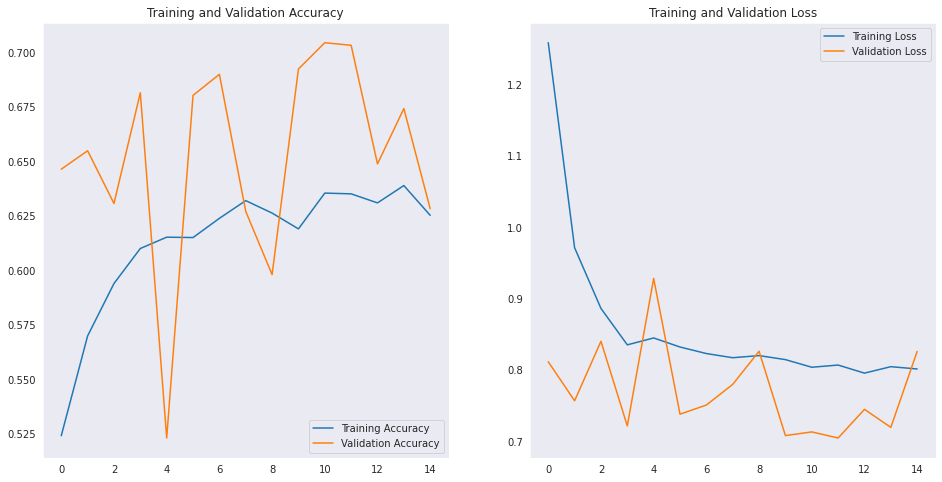

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4.2.2 Initial model - Predictions on test set

In [68]:
initial_test_loss, initial_test_accuracy = model.evaluate(test_generator)

52/52 [==============================] - 5s 94ms/step - loss: 0.7946 - accuracy: 0.6383


##### 4.2.2.1 Initial model - Model accuracy

In [69]:
print('Accuracy of initial model on test set: {:.2f} percent'.format(100*initial_test_accuracy))

Accuracy of initial model on test set: 63.83 percent


##### 4.2.2.2 Initial model - Confusion matrix

In [70]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=(test_generator.n // test_generator.batch_size)+1)
y_pred = np.argmax(Y_pred, axis=1)

In [71]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[637, 216,  82],
       [129, 189, 129],
       [ 15,  28, 231]])

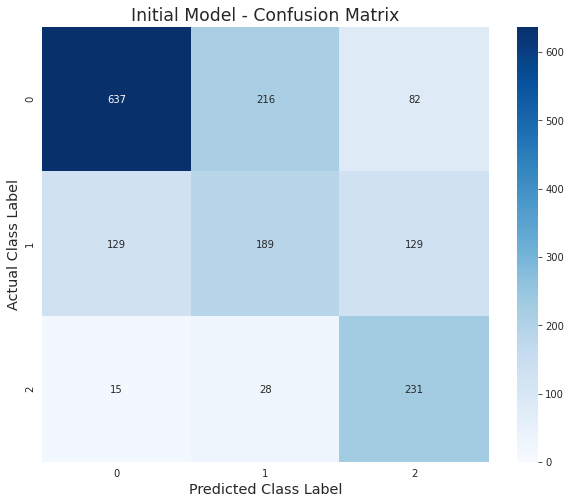

In [72]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Class Label', size='x-large')
plt.ylabel('Actual Class Label', size='x-large')
_ = plt.title('Initial Model - Confusion Matrix',size='xx-large')

##### 4.2.2.3 Initial model - Classification Report

In [73]:
print("Initial model - Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Initial model - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       935
           1       0.44      0.42      0.43       447
           2       0.52      0.84      0.65       274

    accuracy                           0.64      1656
   macro avg       0.59      0.65      0.61      1656
weighted avg       0.66      0.64      0.64      1656



#### 4.2.3 Sample images from test set

We will randomly fetch 10 image files from each of the 3 simplified classes to load and display with their actual label along with their predicted label.

In [74]:
test_generator.class_indices

{'A': 0, 'B': 1, 'C': 2}

In [75]:
from random import sample

test_sample_files = []

# randomly fetch the files
for i in range(len(class_labels)):
    class_name = class_labels[i]
    for file_name in sample(test_files[class_name], 10):
        test_sample_files.append( (class_name, file_name) )
test_sample_files.sort()

In [76]:
# load the images
test_sample_images = []
test_sample_actual_labels = []
for i, (class_name, file_name) in enumerate(test_sample_files):
    img_path = test_directory + '/' + class_name + '/' + file_name
    img = image.load_img(img_path, target_size=(TARGET_IMG_HEIGHT,TARGET_IMG_WIDTH), interpolation='bilinear')
    x = image.img_to_array(img)
    test_sample_images.append(x)
    test_sample_actual_labels.append(test_generator.class_indices[class_name])
    
# convert list into numpy array
test_sample_images = np.asarray(test_sample_images)

In [77]:
# run the prediction
test_sample_predictions = model.predict(test_sample_images)
test_sample_prediction_labels = test_sample_predictions.argmax(axis=1)

In [78]:
test_sample_accuracy_score = 100 * np.sum(test_sample_actual_labels == test_sample_prediction_labels)/len(test_sample_files)
print('Accuracy of initial model: {:.2f} percent'.format(test_sample_accuracy_score))

Accuracy of initial model: 73.33 percent


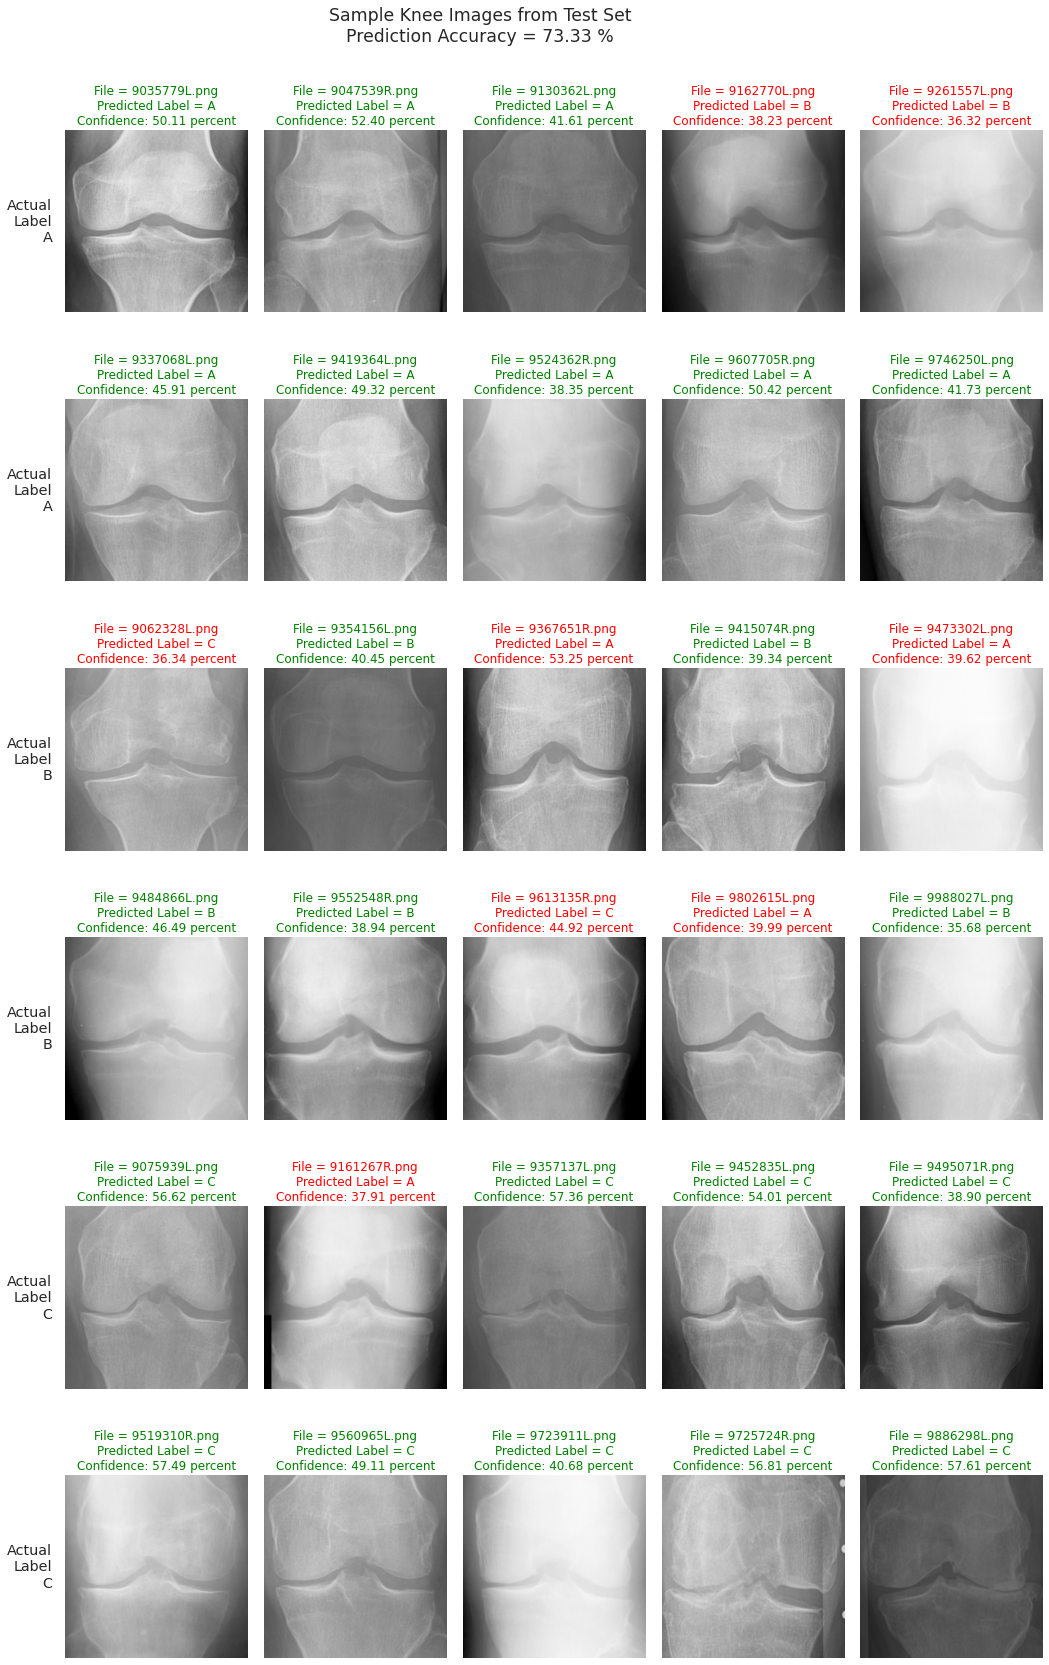

In [79]:
# plot the images

rows = ['Actual\nLabel\n{}'.format(class_labels[i//2]) for i in range(6)]

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 24))

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.05), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

for i in range(6):
    for j in range(5):
        img_num = i*5 + j
        ax = axes[i, j]
        
        # can't just turn off the axis if we want to keep y label
        # must turn each element of axis off
        ax.xaxis.set_visible(False)
        plt.setp(ax.spines.values(), visible=False)
        ax.tick_params(left=False, labelleft=False)
        
        ax.imshow(test_sample_images[img_num].squeeze().astype('uint8'))
        
        file_name = test_sample_files[img_num][1]
        pred_grade = test_sample_prediction_labels[img_num]
        score = 100*np.max(tf.nn.softmax(test_sample_predictions[img_num]))
        title = "File = {}\nPredicted Label = {}\nConfidence: {:.2f} percent".format(file_name, class_labels[pred_grade], score)
        
        # if correctly predicted, set title color to green
        actual_grade = i // 2
        title_color = 'green' if pred_grade == actual_grade else 'red'
        ax.set_title(title, color=title_color) 
_ = plt.suptitle('Sample Knee Images from Test Set\nPrediction Accuracy = {:.2f} %'.format(test_sample_accuracy_score), size='xx-large')
plt.tight_layout(rect=[0.08, 0, 1, 0.95])

### 4.3 Fine-tuning the model

We will now iterate through each layer of the base model (DenseNet201) and freeze all layers except for the last 4. This will allow us to fine-tune the model.

We will also reduce the learning rate to 1e-4, or 0.0001, and increase the number of epochs to 30.

In [80]:
NUM_LAYERS_TO_UNFREEZE = 4
LEARNING_RATE = 0.0001
FINE_TUNING_NUM_EPOCHS = 30

In [81]:
base_model.trainable = True
for layer in base_model.layers[:-NUM_LAYERS_TO_UNFREEZE]:
    base_model.trainable = False

In [82]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [83]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075

In [84]:
num_epochs = FINE_TUNING_NUM_EPOCHS

step_size_train = train_generator.n // train_generator.batch_size + 1
step_size_val = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, 
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator, 
                    validation_steps = step_size_val,
                    epochs = num_epochs, 
                    class_weight = class_weights_dict)

Epoch 1/30
181/181 [==============================] - 85s 423ms/step - loss: 0.7756 - accuracy: 0.6634 - val_loss: 0.8007 - val_accuracy: 0.6211
Epoch 2/30
181/181 [==============================] - 74s 409ms/step - loss: 0.7760 - accuracy: 0.6526 - val_loss: 0.7933 - val_accuracy: 0.6247
Epoch 3/30
181/181 [==============================] - 74s 410ms/step - loss: 0.7504 - accuracy: 0.6615 - val_loss: 0.7563 - val_accuracy: 0.6671
Epoch 4/30
181/181 [==============================] - 74s 411ms/step - loss: 0.7539 - accuracy: 0.6530 - val_loss: 0.7657 - val_accuracy: 0.6513
Epoch 5/30
181/181 [==============================] - 74s 411ms/step - loss: 0.7563 - accuracy: 0.6636 - val_loss: 0.6959 - val_accuracy: 0.6937
Epoch 6/30
181/181 [==============================] - 75s 412ms/step - loss: 0.7488 - accuracy: 0.6700 - val_loss: 0.7483 - val_accuracy: 0.6768
Epoch 7/30
181/181 [==============================] - 74s 410ms/step - loss: 0.7492 - accuracy: 0.6632 - val_loss: 0.7288 - val_ac

#### 4.3.1 After fine-tuning model - Training and Validation Accuracy and Loss

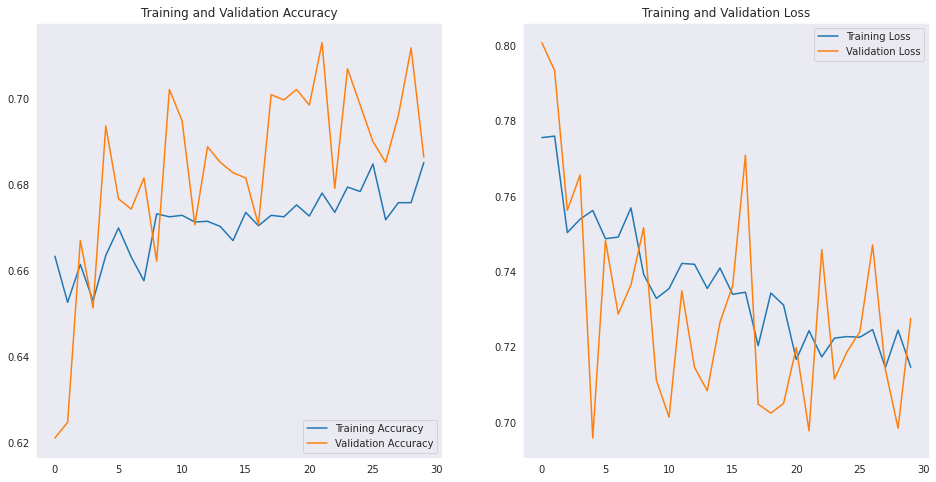

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4.3.2 After fine-tuning model - Predictions on test set

In [86]:
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

52/52 [==============================] - 5s 94ms/step - loss: 0.7188 - accuracy: 0.6806


##### 4.3.2.1 After fine-tuning model - Model accuracy

In [87]:
print('Accuracy of fine-tuned model on test set: {:.2f} percent'.format(100*test_accuracy))

Accuracy of fine-tuned model on test set: 68.06 percent


##### 4.3.2.2 After fine-tuning model - Confusion matrix

In [88]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=(test_generator.n // test_generator.batch_size)+1)
y_pred = np.argmax(Y_pred, axis=1)

In [89]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[695, 211,  29],
       [151, 228,  68],
       [ 23,  47, 204]])

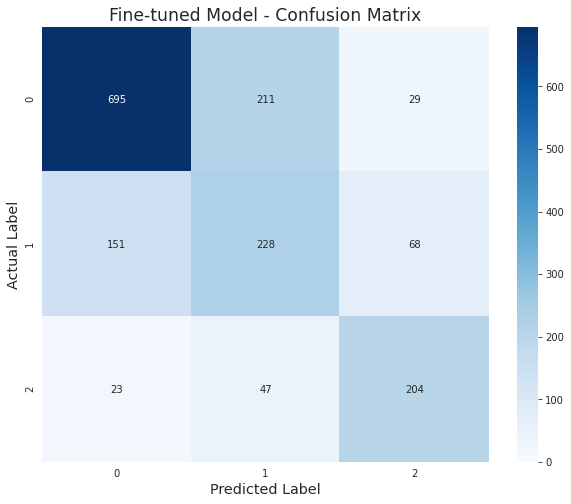

In [90]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Label', size='x-large')
plt.ylabel('Actual Label', size='x-large')
_ = plt.title('Fine-tuned Model - Confusion Matrix',size='xx-large')

##### 4.3.2.3 After fine-tuning model - Classification Report

In [91]:
print("Fine-tuned model - Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Fine-tuned model - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       935
           1       0.47      0.51      0.49       447
           2       0.68      0.74      0.71       274

    accuracy                           0.68      1656
   macro avg       0.65      0.67      0.66      1656
weighted avg       0.69      0.68      0.68      1656



#### 4.3.3 Sample images from test set - after fine-tuning

We will look at the same sample images we earlier retrieved and the grades we now assign.

In [92]:
# run the prediction
fine_tuned_test_sample_predictions = model.predict(test_sample_images)
fine_tuned_test_sample_prediction_labels = fine_tuned_test_sample_predictions.argmax(axis=1)

In [93]:
fine_tuned_test_sample_accuracy_score = 100 * np.sum(test_sample_actual_labels == fine_tuned_test_sample_prediction_labels)/len(test_sample_files)
print('Accuracy of fine-tuned model: {:.2f} percent'.format(fine_tuned_test_sample_accuracy_score))

Accuracy of fine-tuned model: 73.33 percent


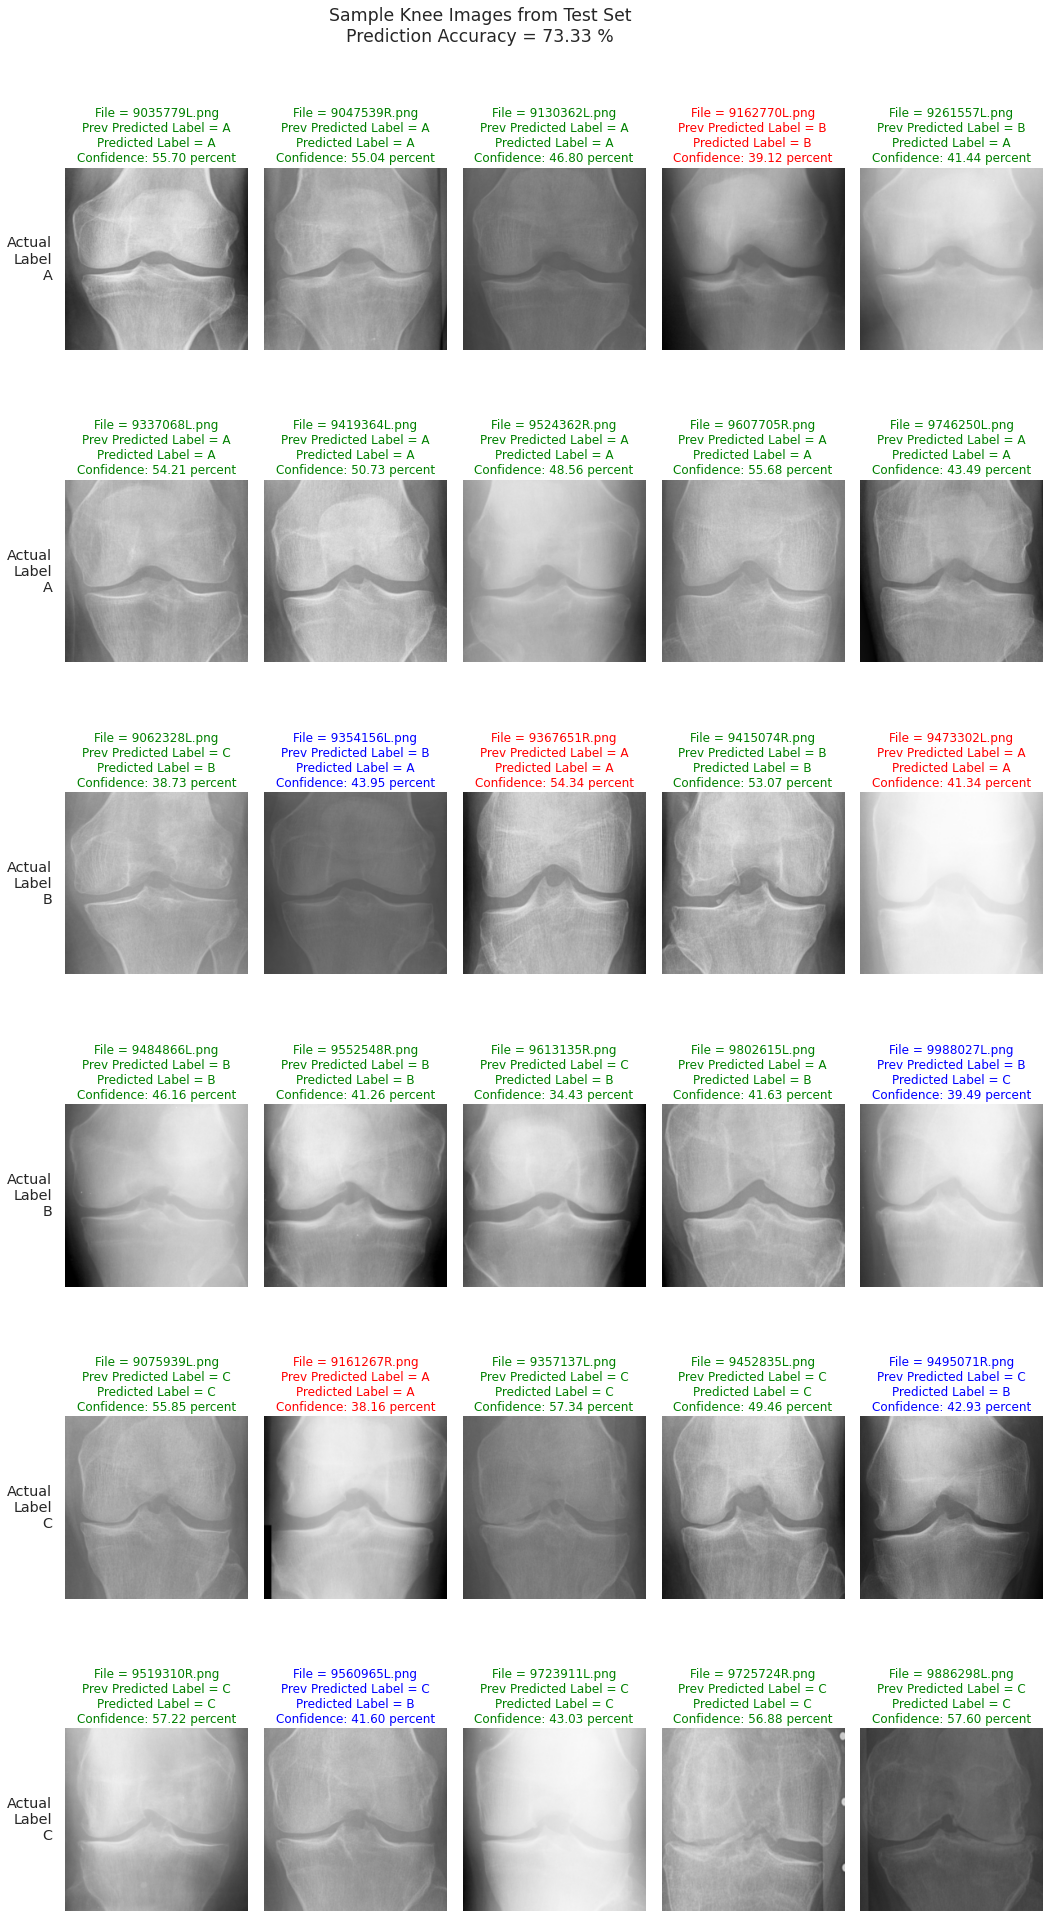

In [94]:
# plot the images

rows = ['Actual\nLabel\n{}'.format(class_labels[i//2]) for i in range(6)]

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 28))

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.05), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

for i in range(6):
    for j in range(5):
        img_num = i*5 + j
        ax = axes[i, j]
        
        # can't just turn off the axis if we want to keep y label
        # must turn each element of axis off
        ax.xaxis.set_visible(False)
        plt.setp(ax.spines.values(), visible=False)
        ax.tick_params(left=False, labelleft=False)
        
        ax.imshow(test_sample_images[img_num].squeeze().astype('uint8'))
        
        file_name = test_sample_files[img_num][1]
        prev_pred_grade = test_sample_prediction_labels[img_num]
        pred_grade = fine_tuned_test_sample_prediction_labels[img_num]
        score = 100*np.max(tf.nn.softmax(fine_tuned_test_sample_predictions[img_num]))
        title = "File = {}\nPrev Predicted Label = {}\nPredicted Label = {}\nConfidence: {:.2f} percent".format(file_name, class_labels[prev_pred_grade], class_labels[pred_grade], score)
        
        # if correctly predicted, set title color to green; if previously correct, but now incorrect, set color to blue
        actual_grade = i // 2
        title_color = 'red'
        if pred_grade == actual_grade:
            title_color = 'green'
        elif prev_pred_grade == actual_grade:
            title_color = 'blue'
        ax.set_title(title, color=title_color) 
_ = plt.suptitle('Sample Knee Images from Test Set\nPrediction Accuracy = {:.2f} %'.format(fine_tuned_test_sample_accuracy_score), size='xx-large')
plt.tight_layout(rect=[0.08, 0, 1, 0.95])